<h2>Importing Required Libraries</h2>

In [1]:
import pandas as pd
import re
import emoji
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

<h2>Reading the Data</h2>

In [2]:
train_df = pd.read_csv("D:/MLProjects/TS/sentiment_data/training.1600000.processed.noemoticon.csv",encoding='latin-1', header=None)

test_df= pd.read_csv("D:\\MLProjects\\TS\\sentiment_data\\testdata.manual.2009.06.14.csv",header = None)

<h2>Quick Inspection of data</h2>

<h3>1. Inspection of Training data</h3>

In [3]:
train_df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


<div>
    <p>Upon initial Inspection of train data these were my observations:</p>
    <ul>
        <li><p>Data has no column names</p></li>
        <li><p>Column 0 is target label</p></li>
        <li><p>I need to check if column 3 has any significance</p></li>
        <li><p>The main Text data in column5 is raw data with links,mentions,emojis, puntuations etc</p></li>
    </ul>
 </div>

<h3>2. Inspection of Test data</h3>

In [4]:
test_df.head()

,0,1,2,3,4,5
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


<div>
    <p>Upon initial Inspection of test data these were my observations:</p>
    <ul>
        <li><p>Data has no column names</p></li>
        <li><p>Column 0 is target label</p></li>
        <li><p>Column 2 is date and time of the respective tweets</p></li>
        <li><p>Column 3 Might be the Topic of tweets</p></li>
        <li><p>The main Text data in column5 is raw data with links,mentions,emojis, puntuations etc</p></li>
    </ul>
 </div>

<h4>Giving data Column names: </h4>

In [5]:
train_df.columns = ['Sentiment','Id', 'Time', 'Query','User', 'Text']



test_df.columns = ['Sentiment','Id', 'Time', 'Topic','User', 'Text']

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Sentiment  1600000 non-null  int64 
 1   Id         1600000 non-null  int64 
 2   Time       1600000 non-null  object
 3   Query      1600000 non-null  object
 4   User       1600000 non-null  object
 5   Text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentiment  498 non-null    int64 
 1   Id         498 non-null    int64 
 2   Time       498 non-null    object
 3   Topic      498 non-null    object
 4   User       498 non-null    object
 5   Text       498 non-null    object
dtypes: int64(2), object(4)
memory usage: 23.5+ KB


<p> There are no null values in both train and test sets </p>

<h4>Checking the significance of Query Column: </h4>

In [8]:
train_df['Query'].value_counts()

NO_QUERY    1600000
Name: Query, dtype: int64

<p> Since all the values are "NO_QUERY" the Query column dosent have any significance"</p>

<h4>Checking Number of different Labels: </h4>

In [9]:
train_df['Sentiment'].value_counts()

0    800000
4    800000
Name: Sentiment, dtype: int64

<p>Since there are only two labels they should be positive and negative, from Observation 0 is negative and 4 is positive</p>

In [10]:
test_df['Sentiment'].value_counts()

4    182
0    177
2    139
Name: Sentiment, dtype: int64

<p>Since there are no label '2's in the train data I will omit the '2's</p>

<h4>Removing the neutral/'2's from test data: </h4>

In [11]:
for index, rows in test_df.iterrows():
    if rows['Sentiment'] == 2:
        test_df = test_df.drop(index)

<h2> Detailed analysis of train data</h2>

<h3>Checking for Duplicates: </h3>

In [12]:
print("Number of Duplicates : ",1600000-train_df['Text'].nunique())

Number of Duplicates :  18534


<h3>Checking for Null Values: </h3>

In [13]:
(train_df['Text'].isna() | (train_df['Text'] == '')).sum()

0

In [14]:
train_df['Text'].head(20)

0     @switchfoot http://twitpic.com/2y1zl - Awww, t...
1     is upset that he can't update his Facebook by ...
2     @Kenichan I dived many times for the ball. Man...
3       my whole body feels itchy and like its on fire 
4     @nationwideclass no, it's not behaving at all....
5                         @Kwesidei not the whole crew 
6                                           Need a hug 
7     @LOLTrish hey  long time no see! Yes.. Rains a...
8                  @Tatiana_K nope they didn't have it 
9                             @twittera que me muera ? 
10          spring break in plain city... it's snowing 
11                           I just re-pierced my ears 
12    @caregiving I couldn't bear to watch it.  And ...
13    @octolinz16 It it counts, idk why I did either...
14    @smarrison i would've been the first, but i di...
15    @iamjazzyfizzle I wish I got to watch it with ...
16    Hollis' death scene will hurt me severely to w...
17                                 about to file

<p> The text column has both uppercase and lower case letters with lots of stopwords and insignificant data as mentioned in the Initial Inspection </P>

<h2>Cleaning and Tokenization Function</h2>

In [15]:
nlp = spacy.load('en_core_web_sm')
def cleanNTokenize(df):

#  Removing Emojis: 

    for col in df.columns:
        if col == 'text':
            df[col] = df[col].apply(lambda x: emoji.demojize(x))

#  Replacing @ Tags with Empty Strings:

    pattern = r'@\w+'
    df['Text'] = df['Text'].apply(lambda x: re.sub(pattern, '', str(x)))
    
#  Replacing # hashtags with Empty Strings: 
    
    pattern = r'#\w+'
    df['Text'] = df['Text'].apply(lambda x: re.sub(pattern, '', str(x)))
    
    
#  Replacing Links with Empty Strings: 

    pattern = r'http\S+|www.\S+'
    df['Text'] = df['Text'].str.replace(pattern, '', regex=True)
    
#  Removing all the stopwords:
    
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in word_tokenize(x) if word.lower() not in stop_words]))

#  Convertin into LowerCase: 
    
    df['Text'] = df['Text'].str.lower()
    
#  Removing Duplicates: 
    
    df.drop_duplicates(subset='Text', inplace=True)
    
#  Replacing punctuations with empty Strings: 
    
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', x))

#  Finally Tokenizing
    
    df['tokenized'] = df['Text'].apply(word_tokenize)
    
    return df

In [16]:
train_df.head(10)

,Sentiment,Id,Time,Query,User,Text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [17]:
train_df = cleanNTokenize(train_df)


<h3>Checking For Null Values</h3>

In [18]:
(train_df['Text'].isna() | (train_df['Text'] == '')).sum()

25

In [19]:
train_df.dropna(subset=['Text'], inplace=True)
train_df = train_df[train_df['Text'] != '']


In [20]:
train_df.head(10)

,Sentiment,Id,Time,Query,User,Text,tokenized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww s bummer shoulda got david carr third ...,"[awww, s, bummer, shoulda, got, david, carr, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset ca nt update facebook texting might cry...,"[upset, ca, nt, update, facebook, texting, mig..."
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest g...,"[dived, many, times, ball, managed, save, 50, ..."
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]"
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,s behaving m mad ca nt see,"[s, behaving, m, mad, ca, nt, see]"
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,whole crew,"[whole, crew]"
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,need hug,"[need, hug]"
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,hey long time see yes rains bit bit lol m ...,"[hey, long, time, see, yes, rains, bit, bit, l..."
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope nt,"[nope, nt]"
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera,"[que, muera]"


In [21]:
test_df = cleanNTokenize(test_df)

<h2>Lemmatization</h2>

In [22]:

def lemmatize_text(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_text = ' '.join(lemmatized_tokens)  # Join lemmatized tokens into a string
    return lemmatized_text



In [23]:

train_df['Lemmatized'] = train_df['tokenized'].apply(lemmatize_text)

In [24]:

test_df['Lemmatized'] = test_df['tokenized'].apply(lemmatize_text)

In [25]:
train_df.head()

,Sentiment,Id,Time,Query,User,Text,tokenized,Lemmatized
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww s bummer shoulda got david carr third ...,"[awww, s, bummer, shoulda, got, david, carr, t...",awww s bummer shoulda got david carr third day
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset ca nt update facebook texting might cry...,"[upset, ca, nt, update, facebook, texting, mig...",upset ca nt update facebook texting might cry ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,dived many times ball managed save 50 rest g...,"[dived, many, times, ball, managed, save, 50, ...",dived many time ball managed save 50 rest go b...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,whole body feels itchy like fire,"[whole, body, feels, itchy, like, fire]",whole body feel itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,s behaving m mad ca nt see,"[s, behaving, m, mad, ca, nt, see]",s behaving m mad ca nt see


In [26]:
X = train_df['Lemmatized']
y = train_df['Sentiment']

<h4>Splitting into Training and validation sets:</h4>

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                    test_size =0.3, random_state = 0)

<h4>Tfidf Vectorization:</h4>

In [28]:
vectorizer = TfidfVectorizer()
X_train_transformed = vectorizer.fit_transform(X_train)

<h3>Linear SVM</h3>

In [29]:
svm = LinearSVC()
svm.fit(X_train_transformed, y_train)

LinearSVC()

In [30]:
X_val_transformed = vectorizer.transform(X_val)

In [31]:
y_pred = svm.predict(X_val_transformed)

<h4>Accuracy Score on Validation Set: </h4>

In [32]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.772656892630764


In [33]:
X_test = test_df['Lemmatized']
y_test = test_df['Sentiment']

In [34]:
X_test_transformed = vectorizer.transform(X_test)

In [35]:
preds1 = svm.predict(X_test_transformed)

<h3> Accuracy Score on Test data using SVM </h3>

In [36]:
accuracy = accuracy_score(y_test, preds1)
print("Accuracy:", accuracy)


Accuracy: 0.7938718662952646


<h3>Logistic Regression: </h3>

In [37]:
from sklearn.linear_model import LogisticRegression
logReg=LogisticRegression(penalty='l2')
logReg.fit(X_train_transformed,y_train)


C:\Users\butta\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [38]:
preds2=logReg.predict(X_test_transformed)

<h3>Accuracy Score on Test Data using LogisticRegression: </h3>

In [39]:
accuracy = accuracy_score(y_test, preds2)
print("Accuracy:", accuracy)


Accuracy: 0.8189415041782729


<h3>Decision Tree :</h3>

In [40]:
# from sklearn.tree import DecisionTreeClassifier
# dTree = DecisionTreeClassifier()
# dTree.fit(X_train_transformed,y_train)

In [41]:
# preds3=dTree.predict(X_test_transformed)

<h3>Accuracy Score on Test Data using Decision Tree</h3>

In [42]:
# accuracy = accuracy_score(y_test, preds3)
# print("Accuracy:", accuracy)


<h3>Naive Bayes: </h3>

In [43]:
from sklearn.naive_bayes import MultinomialNB

nB = MultinomialNB()
nB.fit(X_train_transformed,y_train)

MultinomialNB()

In [44]:
preds4 = nB.predict(X_test_transformed)

<h3>Accuracy Score on Test Data using Gaussian Naive Bayes</h3>

In [45]:
accuracy = accuracy_score(y_test, preds4)
print("Accuracy:", accuracy)


Accuracy: 0.7799442896935933


<h3>Conclusion:</h3>
<b>Logistic Regression gave best accuracy Scofe</b>

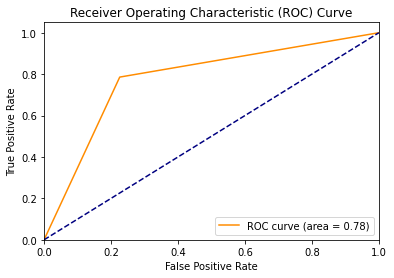

In [46]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_test_binary = np.where(y_test == 4, 1, 0)

fpr, tpr, thresholds = roc_curve(y_test_binary, preds4)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()